In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

%matplotlib inline


# Utility functions

In [2]:
def l2_norm(T1, T2):
    return np.mean((T1 - T2)**2)

def l1_norm(T1, T2):
    return np.mean(abs(T1 - T2))

def linf_norm(T1, T2):
    return np.max(abs(T1 - T2))

In [3]:
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    '''
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1] 
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [4]:
def exact_solution(m):
    x = np.reshape(np.linspace(0, 1, m), (1, -1))
    y = np.reshape(x, (-1, 1))
    return np.sinh(np.pi * y) @  np.sin(np.pi * x) / np.sinh(np.pi)

# Implementing the Methods

#### Boundary condition of the problem with the posibilty to use upwind discretization by using T_w arguement

In [5]:
def boundary_condition(T_, T_w=0.0):
    T = np.copy(T_)
    M = T_.shape[0]
    T[0, 1:-1] = 2 * T_w - T[1, 1:-1]
    x = np.linspace(0.5 / (M - 2), 1.0, M - 2)
    T[-1, 1:-1] = 2*np.sin(np.pi * x) - T[-2, 1:-1]
    T[1:-1, 0] = 2*T_w - T[1:-1, 1]
    T[1:-1, -1] = 2*T_w - T[1:-1, -2]
    return T

#### Explicit and semi-implicit Jacobian methods

In [6]:
def flux_integral_point_jacobi(T, T_w, Dx, Dy):
    M = T.shape[0]
    T_old = np.copy(T)
    for i in range(1, M - 1):
        for j in range(1, M - 1):
            T[i, j] = Dx * (T_old[i + 1, j] + T_old[i - 1, j]) + Dy * (T_old[i, j+1] + T_old[i, j - 1])
    return T

def flux_integral_line_jacobi(T, T_w, Dx, Dy):
    rmesh = T.shape[0]
    cmesh = T.shape[1]
    mesh = rmesh - 2
    m = np.zeros((mesh, mesh), "d")
    d = np.zeros((mesh, 1), "d")
    T_new = np.copy(T)
    for i in range(1, rmesh - 1):
        if i == 1:
            for j in range(1, cmesh - 1):
                if j == 1:
                    d[j - 1] = Dx * T[i + 1, j] + 2*Dx*T_w + 2*Dy*T_w
                    m[j - 1, j-1] = 1 + Dx + Dy
                    m[j - 1, j] = -Dy
                elif j == cmesh - 2:
                    d[j-1] = Dx * T[i + 1, j] +  2 * Dx * T_w + 2 * Dy * T_w
                    m[j - 1, j - 2] = -Dy
                    m[j - 1, j - 1] = 1 + Dy + Dx
                else:
                    d[j - 1] = Dx * T[i + 1, j] + 2 * Dx * T_w
                    m[j - 1, j - 2] = -Dy;
                    m[j - 1, j - 1] = 1 + Dx
                    m[j - 1, j] = -Dy
                    
        else:
            for j in range(1, cmesh - 1):
                if j == 1:
                    d[0] = Dx * (T[i + 1][j] + T[i - 1][j]) + Dy * 2 * T_w
                    m[j - 1][j - 1] = 1 + Dy
                    m[j - 1][j] = -Dy
                elif j == cmesh - 2:
                    d[j - 1] = Dx * (T[i + 1][j] + T[i - 1][j]) + Dy * 2 * T_w
                    m[j - 1][j - 2] = -Dy
                    m[j - 1][j - 1] = 1 + Dy
                else:
                    d[j - 1] = Dx * (T[i + 1][j] + T[i - 1][j])
                    m[j - 1][j - 2] = -Dy
                    m[j - 1][j - 1] = 1
                    m[j - 1][j] = -Dy
        x = TDMAsolver(np.diag(m, -1), np.diag(m, 0), np.diag(m, 1), d)
        for j in range(mesh):
            T_new[i][j + 1] = x[j]
    return T_new
    

#### Explicit and semi-implicit Gauss-Seidel methods

In [7]:
def flux_integral_point_gauss_seidel(T, T_w, Dx, Dy):
    M = T.shape[0]
    for i in range(1, M - 1):
        for j in range(1, M - 1):
            T[i, j] = Dx * (T[i + 1, j] + T[i - 1, j]) + Dy * (T[i, j+1] + T[i, j - 1])
    return T

def flux_integral_line_gauss_seidel(T, T_w, Dx, Dy):
    rmesh = T.shape[0]
    cmesh = T.shape[1]
    mesh = rmesh - 2
    m = np.zeros((mesh, mesh), "d")
    d = np.zeros((mesh, 1), "d")
    for i in range(1, rmesh - 1):
        if i == 1:
            for j in range(1, cmesh - 1):
                if j == 1:
                    d[j - 1] = Dx * T[i + 1, j] + 2*Dx*T_w + 2*Dy*T_w
                    m[j - 1, j-1] = 1 + Dx + Dy
                    m[j - 1, j] = -Dy
                elif j == cmesh - 2:
                    d[j-1] = Dx * T[i + 1, j] +  2 * Dx * T_w + 2 * Dy * T_w
                    m[j - 1, j - 2] = -Dy
                    m[j - 1, j - 1] = 1 + Dy + Dx
                else:
                    d[j - 1] = Dx * T[i + 1, j] + 2 * Dx * T_w
                    m[j - 1, j - 2] = -Dy;
                    m[j - 1, j - 1] = 1 + Dx
                    m[j - 1, j] = -Dy
                    
        else:
            for j in range(1, cmesh - 1):
                if j == 1:
                    d[0] = Dx * (T[i + 1][j] + T[i - 1][j]) + Dy * 2 * T_w
                    m[j - 1][j - 1] = 1 + Dy
                    m[j - 1][j] = -Dy
                elif j == cmesh - 2:
                    d[j - 1] = Dx * (T[i + 1][j] + T[i - 1][j]) + Dy * 2 * T_w
                    m[j - 1][j - 2] = -Dy
                    m[j - 1][j - 1] = 1 + Dy
                else:
                    d[j - 1] = Dx * (T[i + 1][j] + T[i - 1][j])
                    m[j - 1][j - 2] = -Dy
                    m[j - 1][j - 1] = 1
                    m[j - 1][j] = -Dy
        
        x = TDMAsolver(np.diag(m, -1), np.diag(m, 0), np.diag(m, 1), d)
        for j in range(mesh):
            T[i][j + 1] = x[j]
    return T


#### Explicit and semi-implicit SOR methods

In [31]:
def flux_integral_point_sor(T, T_w, Dx, Dy, w):
    M = T.shape[0]
    for i in range(1, M - 1):
        for j in range(1, M - 1):
            T[i][j] = (w * Dx)* (T[i+1][j] + T[i-1][j]) + (w * Dy)* (T[i][j+1] + T[i][j-1]) + (1 - w) * T[i][j]
    return T

def flux_integral_line_sor(T, Tw, Dx, Dy, w):
    rmesh = T.shape[0]
    cmesh = T.shape[1]
    mesh = rmesh - 2
    m = np.zeros((mesh, mesh), "d")
    d = np.zeros((mesh, 1), "d")
    for i in range(1, rmesh - 1):
        if i == 1:
            for j in range(1, cmesh - 1):
                if j == 1:
                    d[0] = (1 - w) * T[i][j] + (w * Dx) * T[i + 1][j] + 2 * (w * Dx) * Tw + 2 * (w * Dy) * Tw
                    m[j - 1][j - 1] = 1 + (w * Dy) + (w * Dx)
                    m[j - 1][j] = -(w * Dy)
                elif j == cmesh - 2:
                    d[j - 1] = (1 - w) * T[i][j] + (w * Dx) * T[i + 1][j] + 2 * (w * Dx) * Tw + 2 * (w * Dy) * Tw
                    m[j - 1][j - 2] = -(w * Dy)
                    m[j - 1][j - 1] = 1 + (w * Dy) + (w * Dx)
                else:
                    d[j - 1][0] = (1 - w) * T[i][j] + (w * Dx) * T[i + 1][j] + 2 * (w * Dx) * Tw
                    m[j - 1][j - 2] = -(w * Dy)
                    m[j - 1][j - 1] = 1 + (w * Dx)
                    m[j - 1][j] = -(w * Dy)
                    
        else:
            for j in range(1, cmesh - 1):
                if j == 1:
                    d[0] = (1 - w) * T[i][j] + (w * Dx) * (T[i + 1][j] + T[i - 1][j]) + (w * Dy) * 2 * Tw
                    m[j - 1][j - 1] = 1 + (w * Dy);
                    m[j - 1][j] = -(w * Dy);
                elif j == cmesh - 2:
                    d[j - 1] = (1 - w) * T[i][j] + (w * Dx) * (T[i + 1][j] + T[i - 1][j]) + (w * Dy) * 2 * Tw
                    m[j - 1][j - 2] = -(w * Dy)
                    m[j - 1][j - 1] = 1 + (w * Dy)
                else:
                    d[j - 1] =  (1 - w) * T[i][j] + (w * Dx) * (T[i + 1][j] + T[i - 1][j])
                    m[j - 1][j - 2] = -(w * Dy)
                    m[j - 1][j - 1] = 1
                    m[j - 1][j] = -(w * Dy)
        x = TDMAsolver(np.diag(m, -1), np.diag(m, 0), np.diag(m, 1), d)
        for j in range(mesh):
            T[i][j + 1] = x[j]
    return T

In [9]:
def converge_flux(flux, mesh, L2, T_w=0.0, max_iter=100000):
    rmesh = mesh + 2
    cmesh = mesh + 2
    T = np.zeros((rmesh, cmesh), "d")
    T = boundary_condition(T, T_w)
    err = 1000.0
    T_old = np.copy(T)
    delta_x = 1.0 / mesh
    delta_y = 1.0 / mesh
    Dy = pow (delta_y, 2) / (2 * (pow(delta_y, 2) + pow(delta_x, 2)))
    Dx = pow (delta_x, 2) / (2 * (pow(delta_y, 2) + pow(delta_x, 2)))
    hist = []
    i = 0
    while err > L2 and i < max_iter:
        i += 1
        if i % 100 == 0:
            print(f"{i}: {err}")
        T = boundary_condition(T, T_w)
        T_old = np.copy(T)
        T = flux(T, T_w, Dx, Dy)
        err = l2_norm(T_old, T)
        hist.append(err)
    return T[1:-1, 1:-1], np.asarray(hist)

#### Implicit method

In [10]:
def implicit_solution(mesh, Tw=0.0):
    row = mesh**2
    col = mesh**2 
    m = np.zeros((row, col), "d")
    Ty = np.zeros((row, 1), "d")
    x = np.linspace(0.5/mesh, 1.0, mesh)    
    delta_x = 1.0 / mesh
    delta_y = 1.0 / mesh
    Dy = pow (delta_y, 2) / (2 * (pow(delta_y, 2) + pow(delta_x, 2)))
    Dx = pow (delta_x, 2) / (2 * (pow(delta_y, 2) + pow(delta_x, 2)))
    for i in range(mesh):
        if i == 0:
            for j in range(mesh):
                k = i*mesh + j
                if j == 0:
                    Ty[k][0] = - 2 * Dx * Tw - 2 * Dy * Tw
                    m[k][k] = - (1 + Dy + Dx)
                    m[k][k + 1] = Dy
                    m[k][k + mesh] = Dx
                            
                elif j == mesh - 1:
                    Ty[k][0] = - 2 * Dx * Tw - 2 * Dy * Tw
                    m[k][k - 1] = Dy
                    m[k][k] = - (1 + Dy + Dx)
                    m[k][k + mesh] = Dx
                else:           
                    Ty[k][0] = - 2 * Dx * Tw
                    m[k][k - 1] = Dy
                    m[k][k] = -(1 + Dx)
                    m[k][k + 1] = Dy
                    m[k][k + mesh] = Dx
        elif i == (mesh -1):
            for j in range(mesh):
                k = i*mesh + j
                if j == 0:
                    Ty[k][0] = - 2 * Dx * np.sin(np.pi*x[j]) - 2 * Dy * np.sin(np.pi * x[j])
                    m[k][k] = - (1 + Dy + Dx)
                    m[k][k + 1] = Dy
                    m[k][k - mesh] = Dx
                elif j == mesh - 1:
                    Ty[k][0] = - 2 * Dx * np.sin(np.pi*x[j]) - 2 * Dy * np.sin(np.pi*x[j])
                    m[k][k - 1] = Dy
                    m[k][k] = - (1 + Dy + Dx)
                    m[k][k - mesh] = Dx
                else:
                    Ty[k][0] = - 2 * Dx * np.sin(np.pi*x[j])
                    m[k][k - 1] = Dy
                    m[k][k] = -(1 + Dx)
                    m[k][k + 1] = Dy
                    m[k][k - mesh] = Dx
        else:
             for j in range(mesh):
                k = i*mesh + j
                if j == 0:
                    Ty[k][0] = - 2 * Dy * Tw
                    m[k][k] = - (1 + Dy)
                    m[k][k + 1] = Dy
                    m[k][k - mesh] = Dx
                    m[k][k + mesh] = Dx
                elif j == mesh - 1:
                    Ty[k][0] = - 2 * Dy * Tw
                    m[k][k - 1] = Dy
                    m[k][k] = - (1 + Dy)
                    m[k][k - mesh] = Dx
                    m[k][k + mesh] = Dx
                else:
                    m[k][k - mesh] = Dx
                    m[k][k - 1] = Dy
                    m[k][k] = -1
                    m[k][k + 1] = Dy
                    m[k][k + mesh] = Dx
                    
    Tx = np.zeros((row, 1), "d")
    for j in range(col - 1):
        for i in range(j + 1, row):
            mul = m[i][j] / m[j][j]
            for r in range(j, col):
                m[i][r] -= (mul * m[j][r]) 
            Ty[i][0] -= (mul * Ty[j][0])

    yy = np.zeros((row, 1), "d")
    for i in range(row):
        yy[i][0] = Ty[i][0];
    for i in range(row - 1, -1, -1):
        if (i == (row -1)):
            Tx[row - 1] = m[row - 1][row - 1]
        for j in range(col - 1, i - 1, -1):
            yy[i][0] -= m[i][j] * Tx[j]
        Tx[i] = yy[i][0] / m[i][i]
    return np.reshape(Tx, (mesh, mesh))

def implicit_solution_sparse(mesh, Tw=0.0):
    """
        Sparse implementation of function impliciti_solution
    """
    row = mesh**2
    col = mesh**2 
    rows = []
    cols = []
    m = []
    Ty = np.zeros((row, 1), "d")
    x = np.linspace(0.5/mesh, 1.0, mesh)    
    delta_x = 1.0 / mesh
    delta_y = 1.0 / mesh
    Dy = pow (delta_y, 2) / (2 * (pow(delta_y, 2) + pow(delta_x, 2)))
    Dx = pow (delta_x, 2) / (2 * (pow(delta_y, 2) + pow(delta_x, 2)))
    for i in range(mesh):
        if i == 0:
            for j in range(mesh):
                k = i*mesh + j
                if j == 0:
                    Ty[k][0] = - 2 * Dx * Tw - 2 * Dy * Tw
                    rows.append(k)
                    cols.append(k)
                    m.append(- (1 + Dy + Dx))
                    
                    rows.append(k)
                    cols.append(k + 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k + mesh)
                    m.append(Dx)
                    
                
                elif j == mesh - 1:
                    Ty[k][0] = - 2 * Dx * Tw - 2 * Dy * Tw
                    
                    rows.append(k)
                    cols.append(k)
                    m.append(-(1 + Dy + Dx))
                    
                    rows.append(k)
                    cols.append(k - 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k + mesh)
                    m.append(Dx)
                    
                else:           
                    Ty[k][0] = - 2 * Dx * Tw
                    rows.append(k)
                    cols.append(k - 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k)
                    m.append(-(1 + Dx))
                    
                    rows.append(k)
                    cols.append(k + 1)
                    m.append(Dy)
                    
                    
                    rows.append(k)
                    cols.append(k + mesh)
                    m.append(Dx)
                
        elif i == (mesh -1):
            for j in range(mesh):
                k = i*mesh + j
                if j == 0:
                    Ty[k][0] = - 2 * Dx * np.sin(np.pi*x[j]) - 2 * Dy * np.sin(np.pi * x[j])  
                    
                    rows.append(k)
                    cols.append(k + 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k)
                    m.append(- (1 + Dy + Dx))
                    
                    rows.append(k)
                    cols.append(k - mesh)
                    m.append(Dx)
                    
                elif j == mesh - 1:
                    Ty[k][0] = - 2 * Dx * np.sin(np.pi*x[j]) - 2 * Dy * np.sin(np.pi*x[j])
                    rows.append(k)
                    cols.append(k - mesh)
                    m.append(Dx)
                    
                    rows.append(k)
                    cols.append(k)
                    m.append(- (1 + Dy + Dx))
                    
                    rows.append(k)
                    cols.append(k - 1)
                    m.append(Dy)
                    
                else:
                    Ty[k][0] = - 2 * Dx * np.sin(np.pi*x[j])
                    
                    rows.append(k)
                    cols.append(k - 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k - mesh)
                    m.append(Dx)
                    rows.append(k)
                    cols.append(k)
                    m.append(- (1+Dx))
                    
                    rows.append(k)
                    cols.append(k + 1)
                    m.append(Dy)
        
        else:
             for j in range(mesh):
                k = i*mesh + j
                if j == 0:
                    Ty[k][0] = - 2 * Dy * Tw
                    
                    rows.append(k)
                    cols.append(k + 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k - mesh)
                    m.append(Dx)
                    
                    rows.append(k)
                    cols.append(k)
                    m.append(-(1+Dy))
                    
                    rows.append(k)
                    cols.append(k + mesh)
                    m.append(Dx)
        
                elif j == mesh - 1:
                    Ty[k][0] = - 2 * Dy * Tw
                    
                    rows.append(k)
                    cols.append(k - 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k + mesh)
                    m.append(Dx)
                    
                    rows.append(k)
                    cols.append(k - mesh)
                    m.append(Dx)
        
                    rows.append(k)
                    cols.append(k)
                    m.append(-(1 + Dy))
        
                else:
                    rows.append(k)
                    cols.append(k - 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k - mesh)
                    m.append(Dx)
                    
                    rows.append(k)
                    cols.append(k)
                    m.append(-1)
                    
                    rows.append(k)
                    cols.append(k + 1)
                    m.append(Dy)
                    
                    rows.append(k)
                    cols.append(k + mesh)
                    m.append(Dx)
        
    Ty_sparse = sparse.csr_matrix(Ty)
    A = sparse.coo_matrix((m, (rows, cols)), shape=(row, col)).tocsr()
    del m
    del rows
    del cols
    Tx = spsolve(A, Ty_sparse)    
    return np.reshape(Tx, (mesh, mesh))


# Results

### Q4
Run your program for Mesh-1 10*10 using Gauss-Seidel routine using initial
condition zero everywhere and let it converge to L2=1e-10 (norm of the residual or
flux integral) . Compare your solution with the exact solution and make sure your
solution trend is alright and the boundary condition is imposed correctly.

l2 = 0.00216


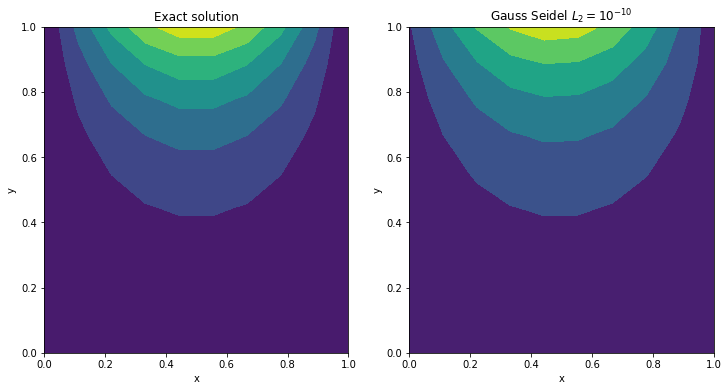

In [11]:
T, hist = converge_flux(flux_integral_line_gauss_seidel, 10, 1e-10)
l2 = l2_norm(T, exact_solution(10))
print(f'l2 = {l2:.5f}')
x = np.linspace(0.0, 1.0, 10)
y = x
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.contourf(x, y, exact_solution(10))
ax2.contourf(x, y, T)

ax1.set_title('Exact solution')
ax2.set_title('Gauss Seidel $L_2 = 10^{-10}$')

ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax1.set_xlabel('x')
ax1.set_ylabel('y');

### Q5:
Run your program for Mesh-2: 20x20 up to Mesh-4: 40x40 using Gauss-Seidel and
let them converge to L2=1e-12. Report the convergence history (both in terms of CPU
time and iteration number) for M-1$\rightarrow$M-4.

In [12]:
q5 = []

##### M1 

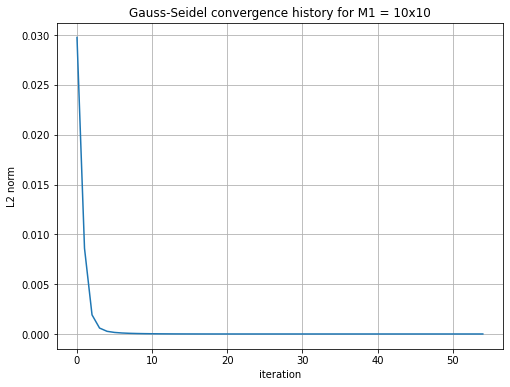

In [13]:
t1 = time()
T, hist = converge_flux(flux_integral_line_gauss_seidel, 10, 1e-12)
t = time() - t1
Te = exact_solution(10)
l2 = l2_norm(T, Te)
l1 = l1_norm(T, Te)
linf = linf_norm(T, Te)
q5.append({"M":10, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})
fig = plt.figure(figsize=(8, 6))
plt.plot(hist)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('L2 norm')
plt.title('Gauss-Seidel convergence history for M1 = 10x10');

##### M2

100: 4.901736667253871e-09


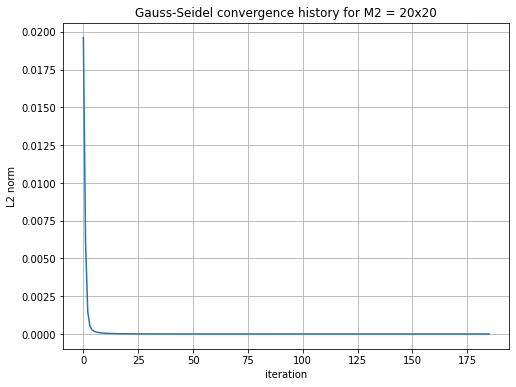

In [14]:
t1 = time()
T, hist = converge_flux(flux_integral_line_gauss_seidel, 20, 1e-12)
t = time() - t1
Te = exact_solution(20)
l2 = l2_norm(T, Te)
l1 = l1_norm(T, Te)
linf = linf_norm(T, Te)
q5.append({"M":20, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})
fig = plt.figure(figsize=(8, 6))
plt.plot(hist)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('L2 norm')
plt.title('Gauss-Seidel convergence history for M2 = 20x20');

##### M4

100: 3.9939992716439855e-07
200: 3.245491985585132e-08
300: 2.78981520827276e-09
400: 2.374534412799014e-10
500: 2.0170330114488004e-11
600: 1.7128037028013058e-12


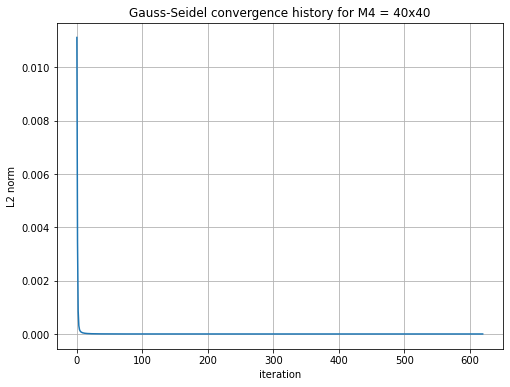

In [15]:
t1 = time()
T, hist = converge_flux(flux_integral_line_gauss_seidel, 40, 1e-12)
t = time() - t1
Te = exact_solution(40)
l2 = l2_norm(T, Te)
l1 = l1_norm(T, Te)
linf = linf_norm(T, Te)
q5.append({"M":40, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})
fig = plt.figure(figsize=(8, 6))
plt.plot(hist)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('L2 norm')
plt.title('Gauss-Seidel convergence history for M4 = 40x40');

In [16]:
df_5 = pd.DataFrame.from_dict(q5)
df_5

,M,L2,L1,L_inf,iterations,cpu_time
0,10,0.002161,0.029283,0.169862,55,0.106449
1,20,0.000459,0.013560,0.085176,186,1.077018
2,40,0.000105,0.006507,0.042506,621,14.309921


### Q6:
Verify the accuracy of your solution against the exact solution and show your code
is a 2 nd -order code by plotting the error norms versus mesh. Report L1, L2 and Linf
for M1$\rightarrow$ M4. Now, manipulate your the boundary condition subroutine in such a
way that for only one boundary cell of your choice the boundary condition is
implemented by a first-order discretization. Do the accuracy analysis again and draw
a conclusion about your result. Visualize the solution in both cases in different plots
and compare them together.

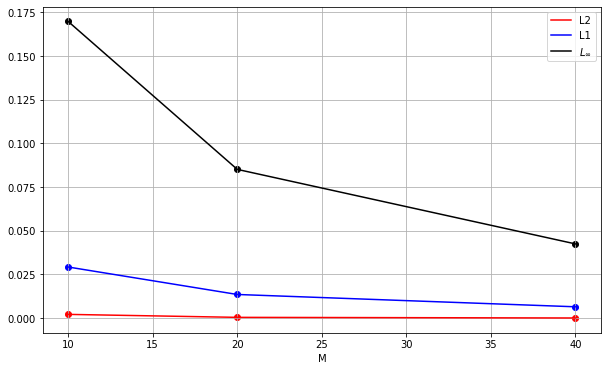

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df_5['M'], df_5['L2'], 'r-', label='L2')
plt.plot(df_5['M'], df_5['L1'], 'b-', label='L1')
plt.plot(df_5['M'], df_5['L_inf'], 'k-', label='$L_{\infty}$')
plt.scatter(df_5['M'], df_5['L2'], color='red')
plt.scatter(df_5['M'], df_5['L1'], color='blue')
plt.scatter(df_5['M'], df_5['L_inf'], color='black')
plt.xlabel('M')
plt.grid(True)
plt.legend();

In [20]:
q6 = []

100: 3.9939992716439855e-07
200: 3.245491985585132e-08
300: 2.78981520827276e-09
400: 2.374534412799014e-10
500: 2.0170330114488004e-11
600: 1.7128037028013058e-12
100: 6.795961435168065e-07
200: 5.7603034717822545e-08
300: 4.9375998911724716e-09
400: 4.199776777902927e-10
500: 3.5670792518242964e-11
600: 3.0290037959521867e-12


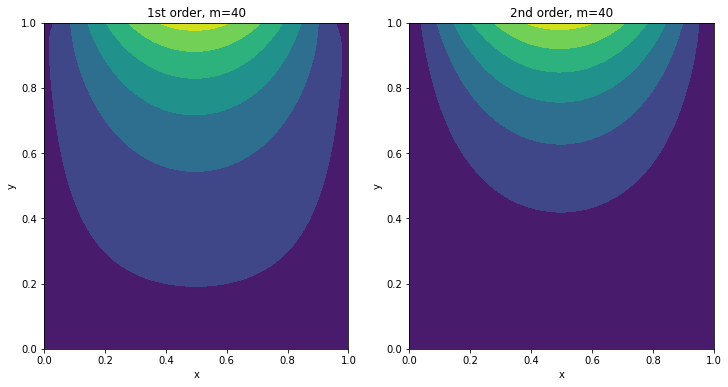

In [21]:
Tw = 0.1
T, hist = converge_flux(flux_integral_line_gauss_seidel, 40, 1e-12)
t1 = time()
T_, hist = converge_flux(flux_integral_line_gauss_seidel, 40, 1e-12, T_w=Tw)
t = time() - t1
Te = exact_solution(40)
l2 = l2_norm(T_, Te)
l1 = l1_norm(T_, Te)
linf = linf_norm(T_, Te)
q6.append({"M":40, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})

x = np.linspace(0.0, 1.0, 40)
y = x
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.contourf(x, y, T_)
ax2.contourf(x, y, T)
ax1.set_title('1st order, m=40')
ax2.set_title('2nd order, m=40')

ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax1.set_xlabel('x')
ax1.set_ylabel('y');

100: 4.901736667253871e-09
100: 8.175879602177041e-09


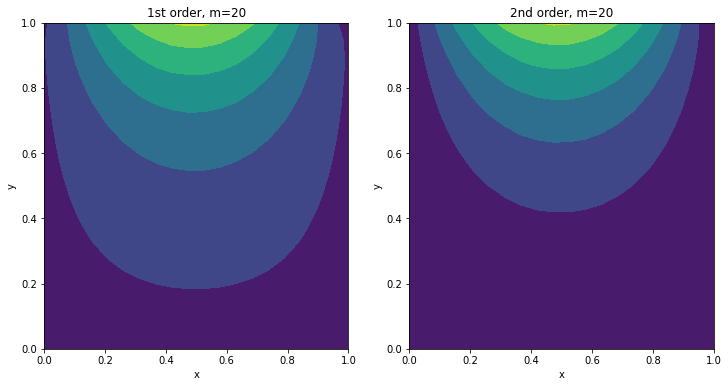

In [22]:

Tw = 0.1
T, hist = converge_flux(flux_integral_line_gauss_seidel, 20, 1e-12)
t1 = time()
T_, hist = converge_flux(flux_integral_line_gauss_seidel, 20, 1e-12, T_w=Tw)
t = time() - t1
Te = exact_solution(20)
l2 = l2_norm(T_, Te)
l1 = l1_norm(T_, Te)
linf = linf_norm(T_, Te)
q6.append({"M":20, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})

x = np.linspace(0.0, 1.0, 20)
y = x
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.contourf(x, y, T_)
ax2.contourf(x, y, T)

ax1.set_title('1st order, m=20')
ax2.set_title('2nd order, m=20')

ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax1.set_xlabel('x')
ax1.set_ylabel('y');


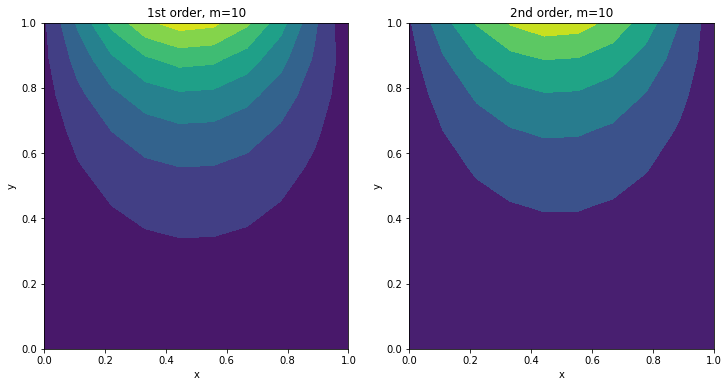

In [23]:

Tw = 0.1
T, hist = converge_flux(flux_integral_line_gauss_seidel, 10, 1e-12)
t1 = time()
T_, hist = converge_flux(flux_integral_line_gauss_seidel, 10, 1e-12, T_w=Tw)
t = time() - t1
Te = exact_solution(10)
l2 = l2_norm(T_, Te)
l1 = l1_norm(T_, Te)
linf = linf_norm(T_, Te)
q6.append({"M":10, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})

x = np.linspace(0.0, 1.0, 10)
y = x
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.contourf(x, y, T_)
ax2.contourf(x, y, T)

ax1.set_title('1st order, m=10')
ax2.set_title('2nd order, m=10')

ax2.set_xlabel('x')
ax2.set_ylabel('y')

ax1.set_xlabel('x')
ax1.set_ylabel('y');

In [25]:
df_6 = pd.DataFrame.from_dict(q6)
df_6

,M,L2,L1,L_inf,iterations,cpu_time
0,40,0.006766,0.076736,0.120789,644,14.574860
1,20,0.007468,0.080741,0.140390,191,1.100250
2,10,0.009830,0.092170,0.184507,56,0.090742


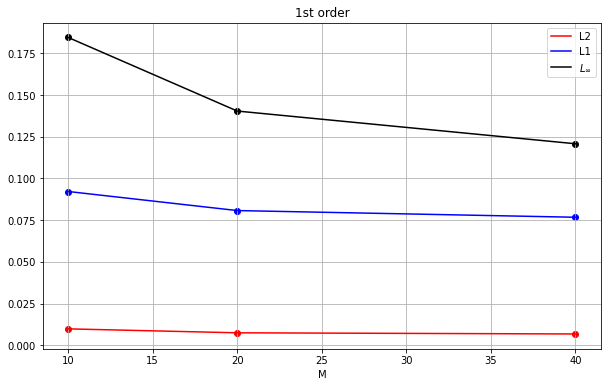

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df_6['M'], df_6['L2'], 'r-', label='L2')
plt.plot(df_6['M'], df_6['L1'], 'b-', label='L1')
plt.plot(df_6['M'], df_6['L_inf'], 'k-', label='$L_{\infty}$')
plt.scatter(df_6['M'], df_6['L2'], color='red')
plt.scatter(df_6['M'], df_6['L1'], color='blue')
plt.scatter(df_6['M'], df_6['L_inf'], color='black')
plt.xlabel('M')
plt.grid(True)
plt.legend()
plt.title('1st order');

### Q7:
Use SOR for Mesh-4 with w=1.1, 1.3, 1.5 as over relaxation factors and compare
your convergence history with Jacobi and Gauss-Seidel (both in terms of CPU time
and iteration number). What is your preferred choice for convergence method and
why it is so?

In [28]:
q7 = []
w = [1.1, 1.3, 1.5]
m = 40
Te = exact_solution(m)

for w_ in w:
    print(f'w={w_}')
    t1 = time()
    T, hist = converge_flux(lambda T, T_w, Dx, Dy:flux_integral_point_sor(T, T_w, Dx, Dy, w_), m, 1e-12)
    t = time() - t1
    l2 = l2_norm(T, Te)
    l1 = l1_norm(T, Te)
    linf = linf_norm(T, Te)
    q7.append({"Method":f"SOR(w = {w_:.1f})", "M":m, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})

print('jacobi:')
t1 = time()    
T, hist = converge_flux(flux_integral_point_jacobi, m, 1e-12)
t = time() - t1
l2 = l2_norm(T, Te)
l1 = l1_norm(T, Te)
linf = linf_norm(T, Te)
q7.append({"Method" : "Jacobi", "M":m, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})

print('gauss:')
t1 = time()
T, hist = converge_flux(flux_integral_point_gauss_seidel, m, 1e-12)
t = time() - t1
l2 = l2_norm(T, Te)
l1 = l1_norm(T, Te)
linf = linf_norm(T, Te)
q7.append({"Method" : "Gauss Seidel", "M":40, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})

w=1.1
100: 4.704837255992534e-07
200: 7.576716726534479e-08
300: 1.6415399573951126e-08
400: 3.641409991351001e-09
500: 8.060227767211197e-10
600: 1.7810696545128631e-10
700: 3.933061768016185e-11
800: 8.683304773277957e-12
900: 1.9169386006292753e-12
w=1.3
100: 4.1607952379240665e-07
200: 3.876778768777288e-08
300: 3.928826676108719e-09
400: 3.9411484438568586e-10
500: 3.943328557557849e-11
600: 3.943644055476598e-12
w=1.5
100: 2.813297602810881e-07
200: 6.943205468087983e-09
300: 1.6351924300859128e-10
400: 3.835645027410445e-12
jacobi:
100: 4.220477894609399e-07
200: 1.083400592594008e-07
300: 4.314956258469549e-08
400: 2.03937294055363e-08
500: 1.0418820158488862e-08
600: 5.5125649565103595e-09
700: 2.9657455231676157e-09
800: 1.6125410095870094e-09
900: 8.864869421511238e-10
1000: 4.952818565334705e-10
1100: 2.8405795425537443e-10
1200: 1.6985496857320774e-10
1300: 1.0802914992674746e-10
1400: 7.450806245763738e-11
1500: 5.629801228845346e-11
1600: 4.638004592544744e-11
1700: 4.09

In [29]:
df_7 = pd.DataFrame.from_dict(q7)
df_7

,Method,M,L2,L1,L_inf,iterations,cpu_time
0,SOR(w = 1.1),40,0.000105,0.006498,0.042510,943,4.202395
1,SOR(w = 1.3),40,0.000105,0.006505,0.042506,659,2.763813
2,SOR(w = 1.5),40,0.000105,0.006511,0.042504,435,1.819248
3,Jacobi,40,0.000105,0.006524,0.042497,100000,232.109158
4,Gauss Seidel,40,0.000105,0.006493,0.042512,1118,2.800989


### Q8-1:
8-1) Solve the system for line SOR with w=1.1 for M1, M2 & M4. You can use Tri-
Diagonal solver for line iteration. Make sure that your solution still is correct and is
similar to the explicit solver result for the same mesh. Report the CPU-time and
compare it with the CPU-time of explicit SOR for the same mesh and over relaxation
factor on one graph. Draw your own conclusion at the end.

In [33]:
q8_1 = []
w_1 = 1.1
w_2 = 1.5
for m in [10, 20, 40]:    
    t1 = time()
    T, hist = converge_flux(lambda T, T_w, Dx, Dy:flux_integral_line_sor(T, T_w, Dx, Dy, w_1), m, 1e-12)
    t = time() - t1
    Te = exact_solution(m)
    l2 = l2_norm(T, Te)
    l1 = l1_norm(T, Te)
    linf = linf_norm(T, Te)
    q8_1.append({"Method" : f"LineSOR(w = {w_1:.1f})", "M":m, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})
    t1 = time()
    T, hist = converge_flux(lambda T, T_w, Dx, Dy:flux_integral_point_sor(T, T_w, Dx, Dy, w_2), m, 1e-12)
    t = time() - t1
    Te = exact_solution(m)
    l2 = l2_norm(T, Te)
    l1 = l1_norm(T, Te)
    linf = linf_norm(T, Te)
    q8_1.append({"Method" : f"PointSOR(w = {w_2:.1f})", "M":m, "L2":l2, "L1":l1, "L_inf":linf, "iterations":len(hist), "cpu_time":t})

df_8_1 = pd.DataFrame.from_dict(q8_1)

100: 5.616474523102408e-11
100: 5.975979061534637e-11
100: 2.6290664770098e-07
200: 5.651622596387176e-09
300: 1.1639466554716888e-10
400: 2.389174250756744e-12
100: 2.813297602810881e-07
200: 6.943205468087983e-09
300: 1.6351924300859128e-10
400: 3.835645027410445e-12


In [35]:
df_8_1

,Method,M,L2,L1,L_inf,iterations,cpu_time
0,LineSOR(w = 1.1),10,0.002161,0.029283,0.169861,36,0.085868
1,PointSOR(w = 1.5),10,0.002161,0.029284,0.169861,68,0.025460
2,LineSOR(w = 1.1),20,0.000459,0.013561,0.085174,125,0.735467
3,PointSOR(w = 1.5),20,0.000459,0.013562,0.085174,126,0.152374
4,LineSOR(w = 1.1),40,0.000105,0.006512,0.042504,422,9.723372
5,PointSOR(w = 1.5),40,0.000105,0.006511,0.042504,435,1.880754


## Q8-2:
8-2) Solve the coefficient matrix for the problem model over M1, M2 & M4 using a
direct matrix solver method such as Gaussian elimination. Make sure that your
solution still is correct and is similar to the explicit solver result for the same mesh.
Report the CPU-time and compare it with the CPU-time of explicit solvers
(L2=1e-12) for the same mesh on one graph. Draw your own conclusion at the end.
You may have to implement sparse programing for M4 case, Why ?

In [34]:
for m in [10, 20]:
    t1 = time()
    T = implicit_solution(m)
    t = time() - t1
    Te = exact_solution(m)
    l2 = l2_norm(T, Te)
    l1 = l1_norm(T, Te)
    linf = linf_norm(T, Te)
    q8_1.append({"Method" : "Implicit Solution", "M":m, "L2":l2, "L1":l1, "L_inf":linf, "iterations":None, "cpu_time":t})

m = 40
t1 = time()
T = implicit_solution_sparse(m)
t = time() - t1
Te = exact_solution(m)
l2 = l2_norm(T, Te)
l1 = l1_norm(T, Te)
linf = linf_norm(T, Te)
q8_1.append({"Method" : "Implicit Solution", "M":m, "L2":l2, "L1":l1, "L_inf":linf, "iterations":None, "cpu_time":t})

df_8_2 = pd.DataFrame.from_dict(q8_1)

In [36]:
df_8_2

,Method,M,L2,L1,L_inf,iterations,cpu_time
0,LineSOR(w = 1.1),10,0.002161,0.029283,0.169861,36.0,0.085868
1,PointSOR(w = 1.5),10,0.002161,0.029284,0.169861,68.0,0.025460
2,LineSOR(w = 1.1),20,0.000459,0.013561,0.085174,125.0,0.735467
3,PointSOR(w = 1.5),20,0.000459,0.013562,0.085174,126.0,0.152374
4,LineSOR(w = 1.1),40,0.000105,0.006512,0.042504,422.0,9.723372
5,PointSOR(w = 1.5),40,0.000105,0.006511,0.042504,435.0,1.880754
6,Implicit Solution,10,0.026155,0.056468,1.436871,NaN,0.330489
7,Implicit Solution,20,0.006430,0.021459,1.410584,NaN,17.958668
8,Implicit Solution,40,0.000107,0.006551,0.052196,NaN,0.011206
